In [2]:
#import libraries
import hdbscan
import pymongo
import umap
import cv2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import save
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering

SystemError: initialization of _internal failed without raising an exception

In [3]:
#load processed data from database
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["big_data_analysis"]
df = pd.DataFrame(list(mydb.processed_col.find({})))

In [4]:
df.shape

(94271, 12)

In [5]:
#load dataset to BERTopic model
docs_english        = df['clean_basic'].to_list()
docs_mulitlingue    = df['clean_english'].to_list() 

In [8]:
#load various models
default_model   = BERTopic()
xlmr_model      = SentenceTransformer('paraphrase-xlm-r-multilingual-v1')
embedder = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')
xlmr_model.save('./models/xlmr')

In [17]:
corpus_default  = default_model

In [10]:
#ecode each tweet in the given dataset in various models
corpus_xlmr     = xlmr_model.encode(df['clean_basic'], show_progress_bar=True)

In [22]:
save('data.npy', corpus_xlmr)

In [23]:
states = df['country_code'].unique()

In [24]:
# set number of clusters
num_clusters = 10
# set clustering model
clustering_model = KMeans(n_clusters=num_clusters)
# train model
clustering_model.fit(corpus_xlmr)

: 

: 

In [1]:
#fit umap model for hdbscan clustering
umap_xlmr = umap.UMAP(n_neighbors=15,
                            n_components=2,
                            min_dist=0.0,
                            metric='cosine').fit_transform(corpus_xlmr)

NameError: name 'umap' is not defined

In [ ]:
#cluster with clustering algorithm hdbscan
hdb_model = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=8)

In [ ]:
#train with hdb models
train_min       = hdb_model.fit(umap_min)
train_mpnet     = hdb_model.fit(umap_mpnet)
train_xlmr      = hdb_model.fit(umap_xlmr)
train_distil    = hdb_model.fit(umap_distil)

In [ ]:
#train using corpuses and fit_transform
#topics_min, probs_min       = min_model.fit_transform(docs_english)
#topics_mpnet, probs_mpnet   = mpnet_model.fit_transform(docs_english)
topics_xlmr, probs_xlmr     = xlmr_model.fit_transform(docs_mulitlingue)
#topics_distil, probs_distil = distil_model.fit_transform(docs_english)

In [ ]:
#train using corpuses and fit function
trained_min     = BERTopic().fit(docs_english, corpus_min)
trained_mpnet   = BERTopic().fit(docs_english, corpus_mpnet)
trained_distil  = BERTopic().fit(docs_english, corpus_distil)
trained_xlmr    = BERTopic().fit(docs_mulitlingue, corpus_xlmr)

In [ ]:
#clusters using KMeans
# set clustering model Kmeans
#KMeans_model    = KMeans(n_clusters=2)
#Kmeans_min      = KMeans_model.fit(corpus_min)
#Kmeans_mpnet    = KMeans_model.fit(corpus_mpnet)
Kmeans_xlmr     = KMeans_model.fit(corpus_xlmr)
#Kmeans_distil   = KMeans_model.fit(corpus_distil)

In [21]:
def plot_clusters(data_2d, cluster_labels):
    result = pd.DataFrame(data_2d, columns=['x', 'y'])
    result['labels'] = cluster_labels
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.figure()
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, 
                cmap='hsv_r')
    plt.colorbar()

In [26]:
df['length'].head()

0    15
1     7
2    20
3    57
4    36
Name: length, dtype: int64

<AxesSubplot: xlabel='length', ylabel='Density'>

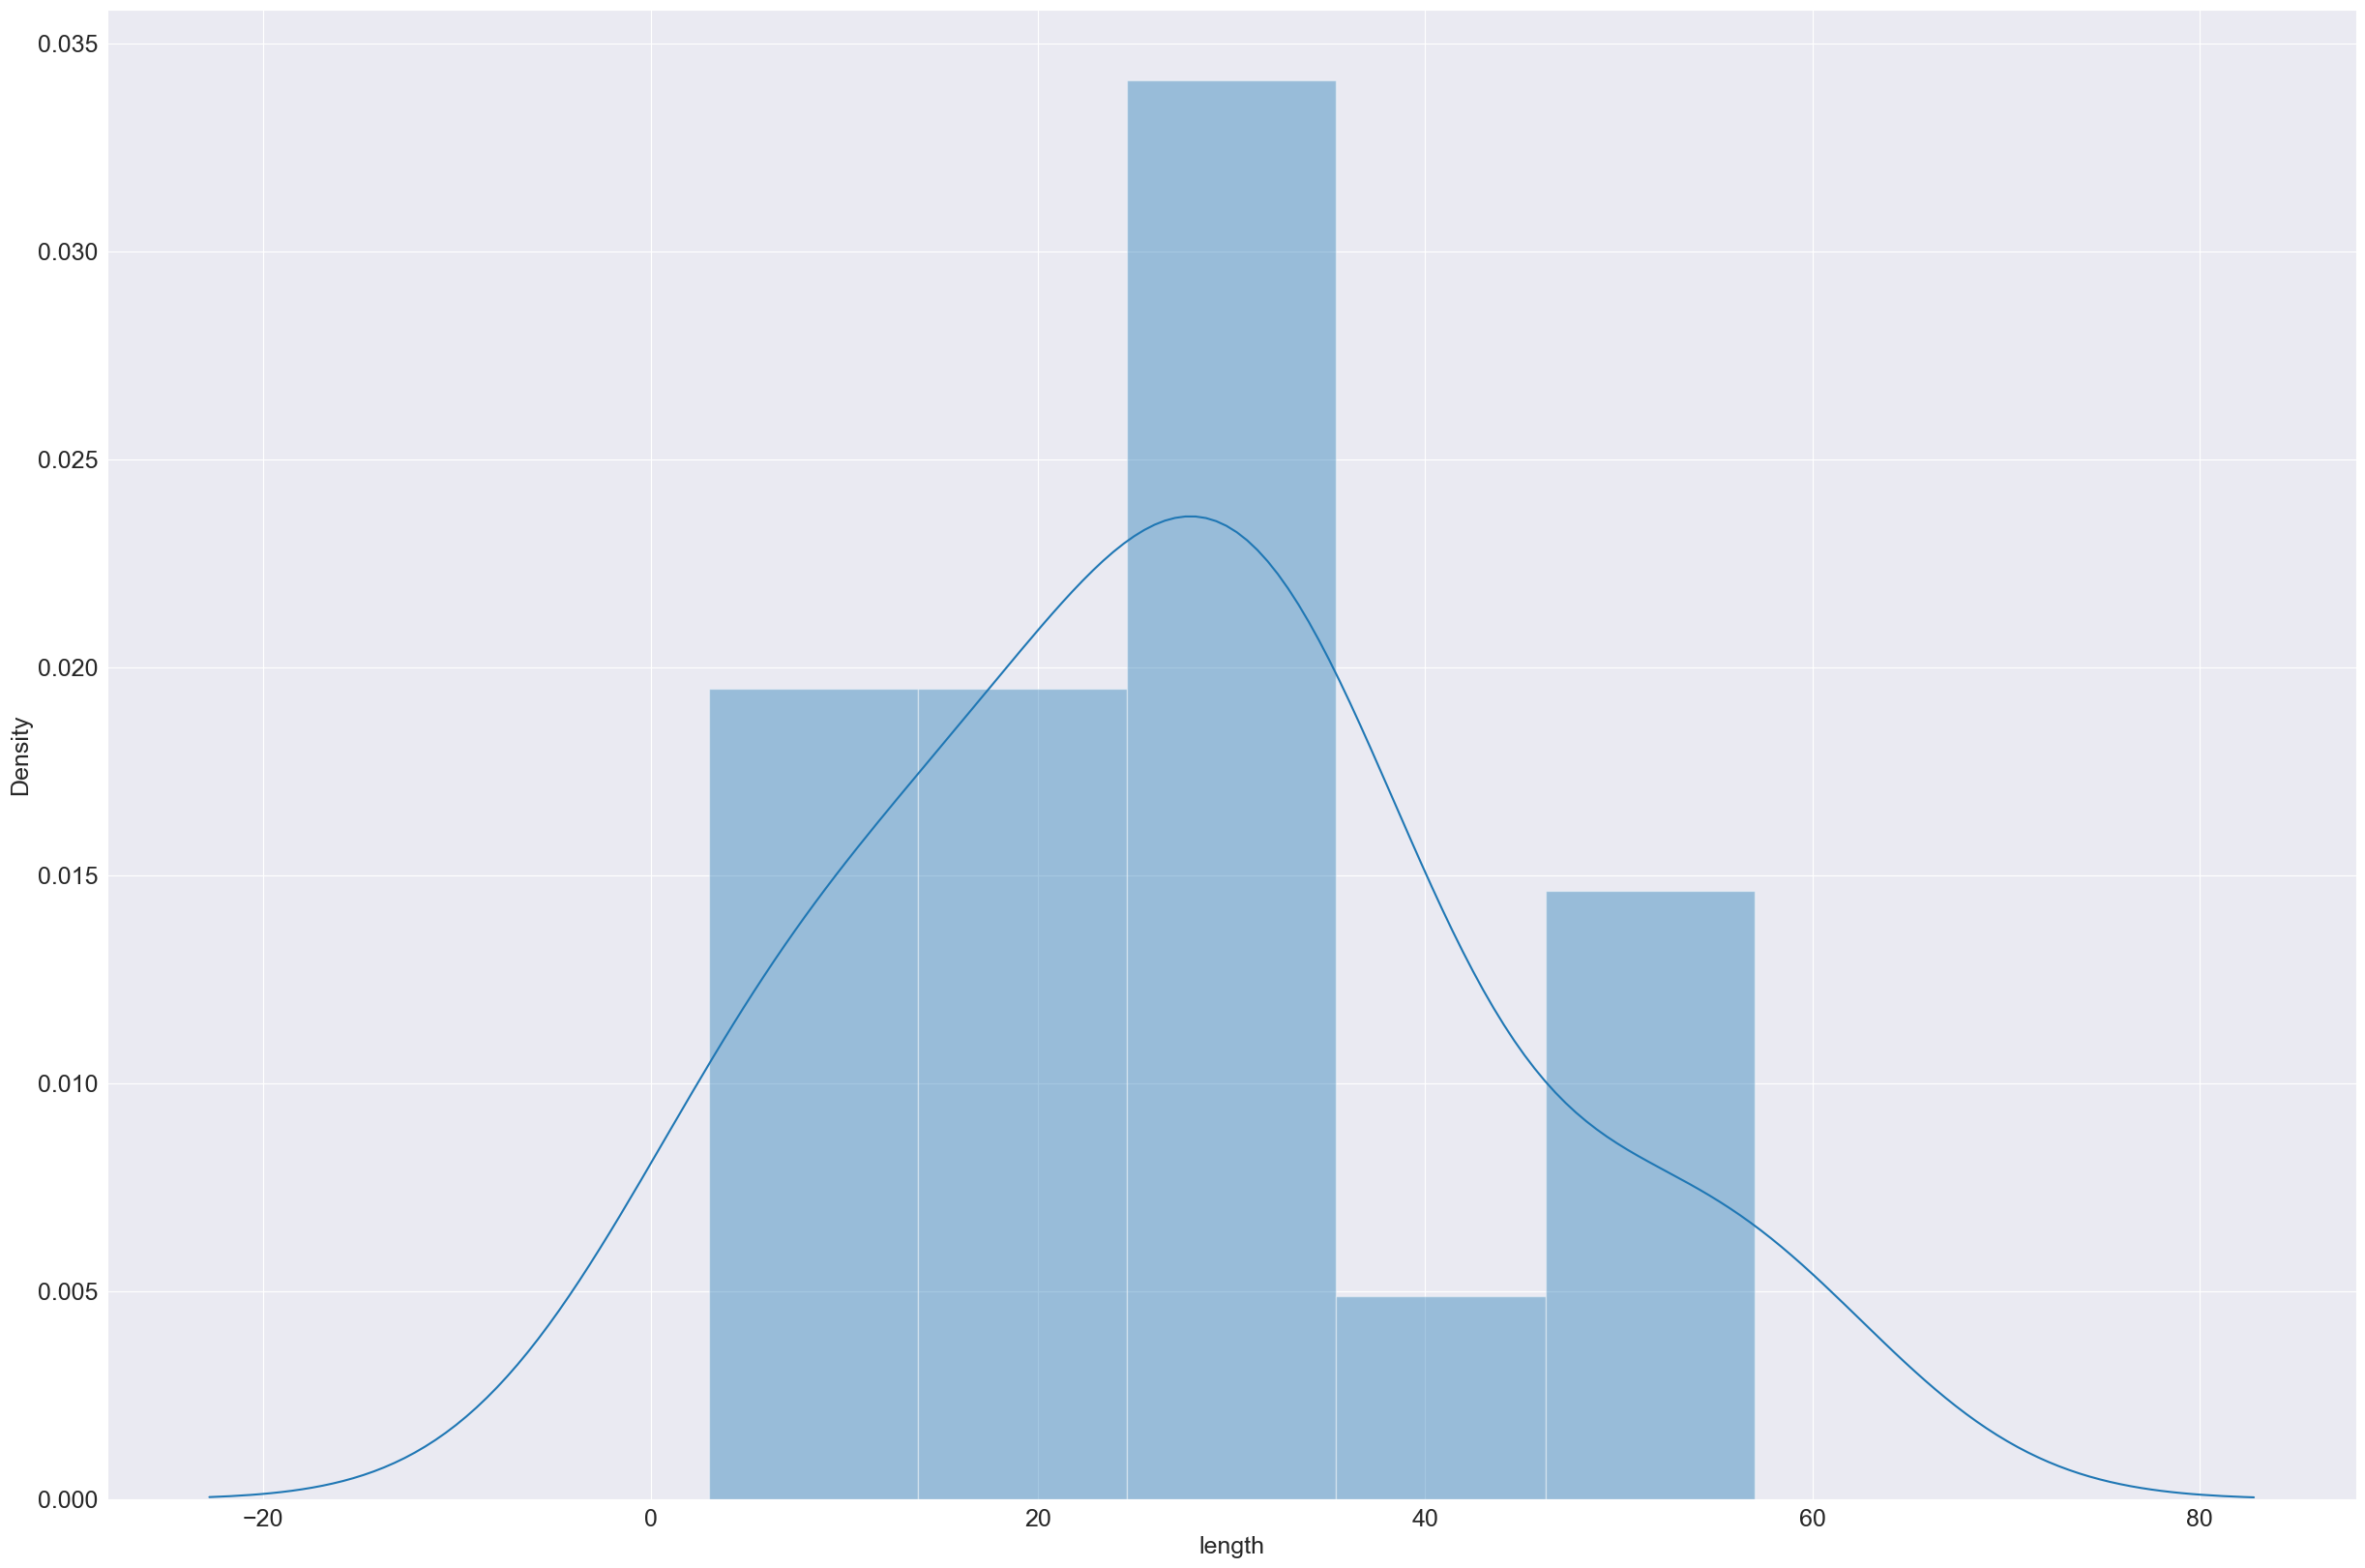

In [30]:
#plot graph of with length of tweets
data = df['length']
sns.set_style(style="darkgrid")
sns.distplot(data)

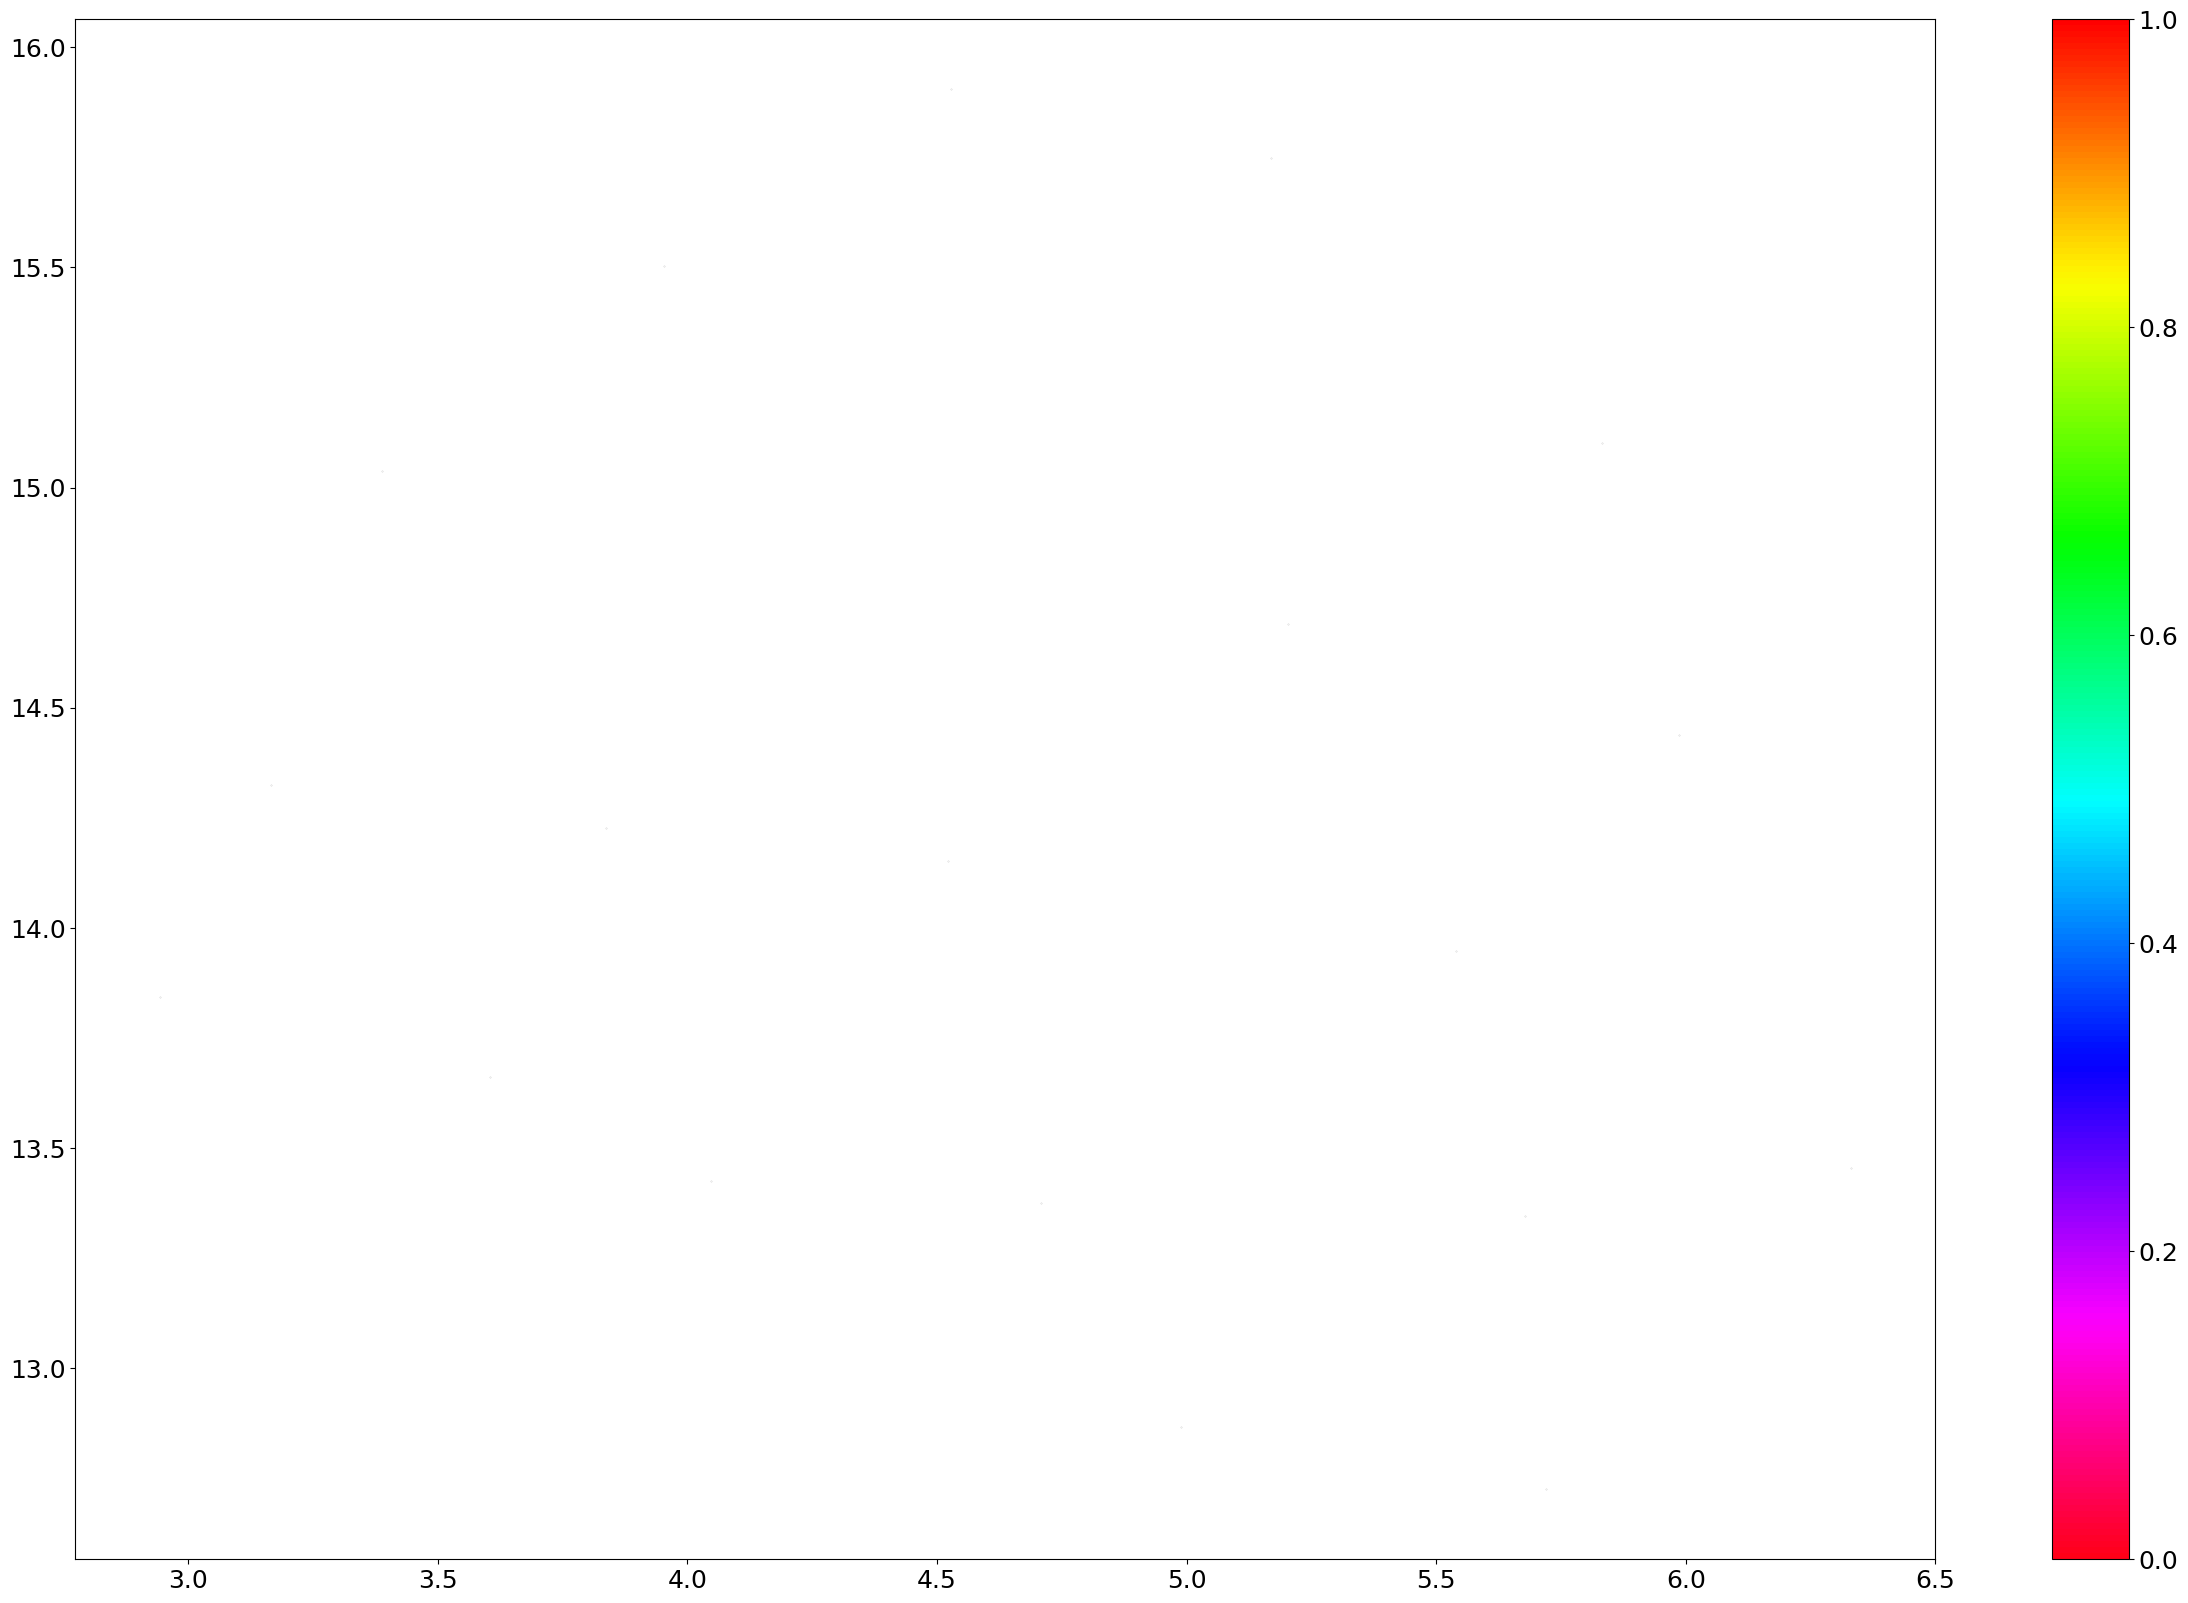

In [22]:
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams.update({'font.size': 18})
plot_clusters(umap_min, train_min.labels_)

In [ ]:
def class_tf_idf_topic_creation(df, cluster_labels, n=10, max_df=1.0):
    m = len(df)
    class_df = pd.DataFrame(df['Text'].values, columns=['text'])
    class_df['class'] = cluster_labels
    class_df['ID'] = range(len(class_df))
    class_df = class_df[class_df['class'] != -1]
    sent_per_class = class_df.groupby(['class'], 
                                      as_index=False).agg({'text': ' '.join})
    count = CountVectorizer(stop_words='english', 
                            max_df=max_df).fit(sent_per_class.text.values)
    t = count.transform(sent_per_class.text.values).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    words = count.get_feature_names()
    classes = list(sent_per_class['class'])
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) \
                           for j in indices[i]][::-1] \
                   for i, label in enumerate(classes)}
    return top_n_words

top_n_words = class_tf_idf_topic_creation(df_1, model.labels_)
top_n_words

In [ ]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

In [1]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df['clean_english'].to_list())

NameError: name 'BERTopic' is not defined